
# Capstone: Pneumonia Classification by X-Rays

*Prepared by:  
Sibel Tanoglu  
GA-DSI-CC9*

## *Technical Report*

### 1) Executive Summary

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Typically symptoms include some combination of productive or dry cough, chest pain, fever, and trouble breathing. Severity is variable.

Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications and conditions such as autoimmune diseases. Diagnosis is often based on the symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired with community, hospital, or health care associated pneumonia.

The goal of this project is constructing a convolutional neural network (CNN) to identify whether a patient has pneumonia or not by classifying their chest X-ray images. This project is adequately scoped and focuses on one specific type of disease rather than targeting multiple diagnosis. Creating a robust algorithm that provides fast and accurate diagnosis is beneficial for both patients and medical proffesionals.

### 2) Data Collection

The data used was collected from Mendeley public datasets repository and described as Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification. Chest X-ray images were selected from retrospective cohorts of pediatric patients of one to five years old from Women and Children’s Medical Center, Guangzhou. The dataset consists of 5,863 X-Ray images (JPEG) and 2 categories: Pneumonia/Normal. Pneumonia images are annotated as Bacterial or Viral in file names that were later separated to build a multiclass classification network.  
Approximately 10% of the images from each category were moved to test folder to be used in validation of the model.

<img src="./media/data.png" alt="drawing" width="500"/>

### 3) Data Exploration & EDA

Most images were at least 224 × 224 pixels and contained RGB color channels. Images that were smaller than
224 x 224 pixels or in greyscale were removed from analysis. This was done after getting poor results with preprocessed images to smaller size and grayscale mode even though it gives faster results.

<img src="./media/size_dist.png" alt="drawing" width="1000"/>

A function called`pair_plot` was defined to plot the mormal and pneumonia positive images side by side to get a glimpse on the difference. Pneumonia positive images seems to be more faint as the borders between organs are less sharp because of the soft tissue (water) in the lungs.  
Black: Air  
Dark Grey: Fat  
Light Grey: Soft tissue  
Off white: Bone  
Bright white: Metal  

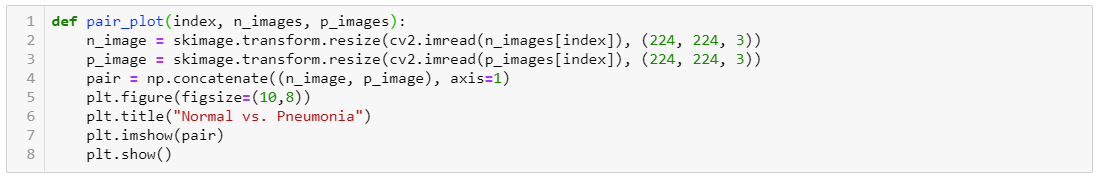

<img src="./media/pair.png" alt="drawing" width="1000"/>

### 4) Data Preprocessing & Augmentation

The X-ray images were resized as (224 x 224 x 3) three dimensional tensor so that they all have same number of input variables. Also, the pixel values were downscaled multiplying by .1/255 to avoid extremely high output values.

All images were manually reviewed and found that there are a lot of variations for such a small dataset. The hight/width ratio, zooming range, angle of the body etc features differ among differen Xray images. Even the physical dimensions of images are vastly different. This makes it harder to train a model that will give high accuracy rate. Image data generator class was utilized to generate additional images within train data with optimal rotation_range, shear_range, zoom_range, horizontal_flip (mirroring randomly selected images) to get additional observations to train the model with. The augmentation occurs on the fly during the training process and a slighly different version of each image is used as input per epoch. The parameter values were tuned numerous times until getting decent predictive performance from models.  

After data generator object was initialized with optimal parameter values, directory iterator method `flow_from_directory` was used to generate batches of numpy arrays of augmented images from train directory. For validation images, only `rescale` parameter was used since augmentation is necessary to improve learning process but not for validating.

<img src="./media/generator.png" alt="drawing" width="1000"/>

A function called `plotImages` was defined to plot random variations of same X-ray image. The function was executed numerous times to make sure the most informative areas (lungs) would not be cropped from the images with given parameter values. 

<img src="./media/augmented.png" alt="drawing" width="1000"/>

### 5) Neural Network Arthitecture

The data was fit to a series of simple sequential and convolutional networks. With the guadiance of success metrics on both train and validation data, the complexity of the models were gradually increased and the parameters wer tuned fo the best performance. Since the model got more complex with slow learning rate and took hours to execute, an AWS EC2 P3 instance with machine learning environment was setup to continue model training remotely. However, the instance was shut down after getting a better performance with Google Colab virtual instance.

This report covers the best convolutional network that performed the best in multiple success metrics (Validation Accuracy, Precision, Recall) so far. However, there is a different version of the model has currenlty been executing.

***Custom CNN***

After a series of trials, it's discovered that the network learns from the data gradually so the inital layers have less neurons than the middle layers. Also, multiple `Dropout` layers were added with optimal rate to combat overfitting. Decreasing learning rate to "slow cook" the network did not affect the accuracy much so it was kept with default value. Instead, `epochs` were increased to 250 so that the data size would be artificially boosted each iteration. `BatchNormalization` layer was added right before the output layer to scale the input so that the output has near to a zero mean and unit standard deviation, to allow for faster and more resilient training. As the network becomes deeper, batch normalization start to play an important role.

<img src="./media/network.png" alt="drawing" width="1000"/>

Since 250 epochs takes a very long time to execute, checkpoint was defined through callbacks to save the weights of best model. If there is an increase in validation accuracy score, the weights would be automatically saved in provided path in .hdf5 format.

### 6) Interpretation

The training/validation accuracy and loss graphs were created from 100 epochs version of above convolutional network. It may be considered a time series graph of the network's performance. The model learns gradually but the overall performance has an upward trend. The X-ray images from different classes are very similar that, the network captures most informative inputs after numerous iterations and weight adjustments.

<img src="./media/evaluation.png" alt="drawing"  height="100"/>

- Train Accuracy: 84%  
- Validation Accuracy: 86%  
- Precision: 72%  
- Recall 98%

***Confusion Matrix***

0 = Bacterial  
1 = Normal  
2 = Viral

The model learned the bacterial pneumonia the best as it is the majority class with highest number of observations. However, true positive and true negative rates for both normal and viral pneumonia are not too high either. Only five patients were classified healthy while in fact they have bacterial pneumonia. As bacterial pneumonia is the most fatal, it is recommended to minimize this value which would optimize the recall score. Perhaps by increasing the complexity of the model.

<img src="./media/confusion_matrix.png" alt="drawing"  height="100"/>

### 7) Flask App

A web application was built where user uploads a chest x-ray image and immediately receives the probability rates of 3 distinct diagnoses:   
1- Normal  
2- Bacterial Pneumonia  
3- Viral Pneumonia  

For the app, saved weights of the best model was loaded to the empth CNN arthitecture. Then, thr user input was passed to the data iterator method of Keras data generator object, finally evaluated by the model to generate predicted probabilities of each of the three classes.

<img src="./media/flask.png" alt="drawing" width="800"/>

### 8) Next Steps

- Collecting more data.
- Adding more complexity in model and using gridsearch functionality.
- Creating additional model with PyTorch library and compare the results.
- Researching on how to detect most informative pixels on X-ray (highest weights) and highlight them on image output.
- Having radiologists interpret same X-rays and compare their performance with model’s performance.